In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import plotly as plty
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.optimize import curve_fit

# Vaccination Rate Trends Dashboard for Udacity WebDev Project

Tasked with deploy a dashboard using a little bit of html, bootstrap, plotly and flask, I went immediately to kaggle to try to find something current and interesting. Increases in rates of infectious diseases recently in [Seattle](https://www.seattletimes.com/seattle-news/politics/amid-measles-outbreak-state-house-panel-moves-to-ban-personal-vaccine-exemptions/) have brought into focus the problem of increases in personal vaccination exceptions. Being 31, and close to child brining into the world age, I decided to look at trends with this recent [dataset](https://www.kaggle.com/broach/california-kindergarten-immunization-rates).

In [2]:
df1 = pd.read_csv('geoData.csv')

In [3]:
df1.head()

,longitude,latitude,school_code,countyMatch,isSchool
0,-122.215864,37.803399,7092463,1,1
1,-121.882682,37.716306,6972533,1,1
2,-122.196244,37.758459,7082266,1,1
3,-122.234422,37.782892,6910343,1,1
4,-122.243885,37.768844,6967434,1,1


First dataframe contains longitude and latitude, as well as school ids.

In [4]:
df2 = pd.read_csv('InfantData.csv')

In [5]:
df2.head()

,COUNTY,Cases,Hospitalizations,Deaths,Case_Rate
0,ALAMEDA,10,3,0,1.0
1,ALPINE,0,0,0,0.0
2,AMADOR,0,0,0,0.0
3,BUTTE,6,5,0,5.1
4,CALAVERAS,0,0,0,0.0


Second contains infant disease and death cases for 2015, and will be ignored from here forward.

In [6]:
df3 = pd.read_csv('pertusisRates2010_2015.csv')

In [7]:
df3.head()

,county,Cases2010,Rate2010,Cases2011,Rate2011,Cases2012,Rate2012,Cases2013,Rate2013,Cases2014,Rate2014
0,CALIFORNIA,9159,24.55,3016,8.03,1023,2.70,2537,6.64,10831,28.35
1,ALAMEDA,423,30.21,206,14.59,62,4.35,124,8.55,354,24.41
2,ALPINE,0,0.00,0,0.00,0,0.00,0,0.00,0,0.00
3,AMADOR,4,10.56,11,29.48,1,2.74,2,5.52,1,2.76
4,BUTTE,32,14.55,16,7.26,3,1.36,33,14.87,30,13.52


Third dataframe contains rates of infectious diseases for all the counties from 2010 to 2014.

In [8]:
df4 = pd.read_csv('StudentData.csv', encoding='iso-8859-1')

In [9]:
df4.head()

,schoolType,COUNTY,SCHOOL,school_code,n,nMMR,nDTP,nPolio,nPBE,nPME,year
0,PRIVATE,ALAMEDA,A CHILD'S WORLD MONTE,7092463,12,12,11,9,0,0,2000
1,PRIVATE,ALAMEDA,ACAD,6972533,15,15,15,15,0,0,2000
2,PRIVATE,ALAMEDA,ACTS CHRISTIAN ACADEM,7082266,19,17,17,17,0,0,2009
3,PRIVATE,ALAMEDA,ACTS CHRISTIAN ACADEM,7082266,23,6,22,23,0,0,2010
4,PRIVATE,ALAMEDA,ACTS CHRISTIAN ACADEM,7082266,27,27,27,27,0,0,2006


Fourth one contains most of the data I am particularily interested in, its got the vaccination and exemption rates for all the different schools and counties for multiple years across the state. Dividing nMMR (measles mumps rubella), nDTP (diptheria tetanus pertussis) and nPolio by n gives vaccination rates. These will be compared against nPBE rates (personnel belief exceptions). Using df1 and some plotly libraries geographic trends will be exmained. 

## Statewide Trends since 2000

In [10]:
v_year_summary = df4.groupby('year')[['nDTP', 'nMMR', 'nPolio', 'nPBE', 'n']].mean()

In [11]:
v_year_summary['PBE_rate'] = v_year_summary['nPBE']/v_year_summary['n']
v_year_summary['DTP_rate'] = v_year_summary['nDTP']/v_year_summary['n']
v_year_summary['MMR_rate'] = v_year_summary['nMMR']/v_year_summary['n']
v_year_summary['Polio_rate'] = v_year_summary['nPolio']/v_year_summary['n']

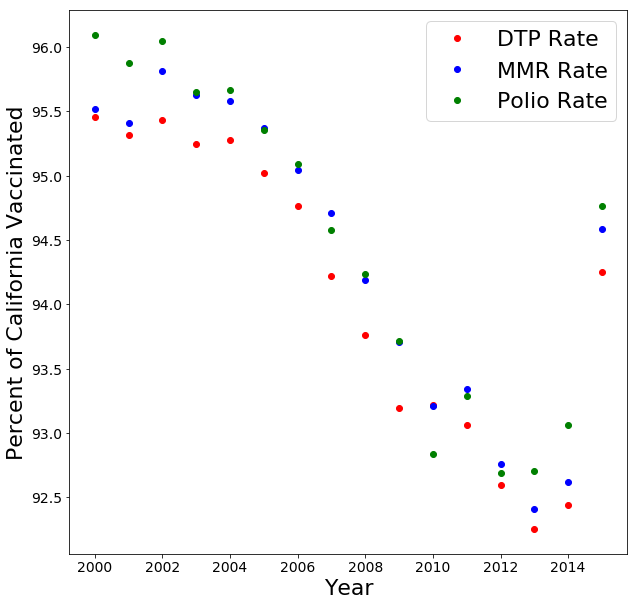

In [12]:
plt.figure(figsize=(10,10));
plt.plot(v_year_summary['DTP_rate']*100, 'ro');
plt.plot(v_year_summary['MMR_rate']*100, 'bo');
plt.plot(v_year_summary['Polio_rate']*100, 'go');
plt.legend(['DTP Rate', 'MMR Rate', 'Polio Rate'], fontsize=22);
plt.xlabel('Year', fontsize=22);
plt.ylabel('Percent of California Vaccinated', fontsize=22);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.savefig('figure_1.png');

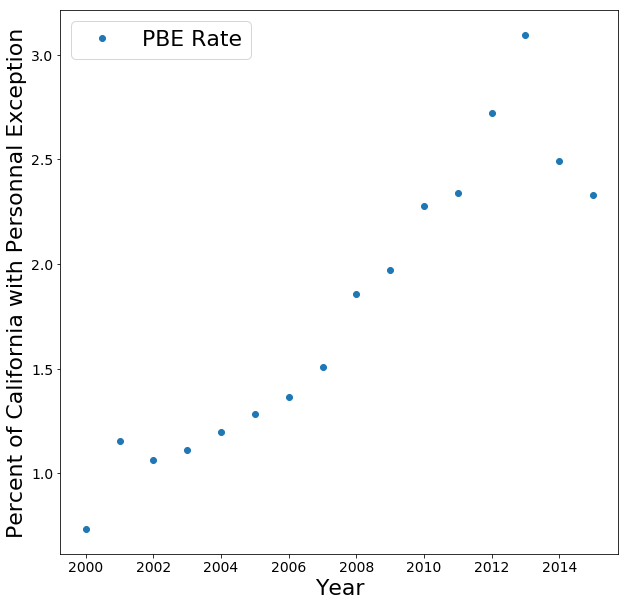

In [13]:
plt.figure(figsize=(10,10));
plt.plot(v_year_summary['PBE_rate']*100, 'o');
plt.legend(['PBE Rate'], fontsize=22);
plt.xlabel('Year', fontsize=22);
plt.ylabel('Percent of California with Personnal Exception', fontsize=22);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.savefig('figure_2.png');

Well thats pretty interesting. The decade starting in 2003 was one in which the statewide personnal exception rate steadily climbed from near 1% to up near 3%. At the same time the overall vaccination rates dropped from around 96% on average to slightly below 93%. The three years from 2013-2015 then showed a reversed trend. Perhaps some relevant programs were instated to encourage vaccinations around this time?

Seems there is a clear correlation between the increase in PBEs and the decrease in vaccination rates. Overall it seems that people getting exceptions get exceptions for all three vaccines, these are all highly correlated with each other. Interestingly the DTP vaccination right is consistently about 0.5% below the other two.

## County wide rate trends versus year

In [14]:
agg_dict = {'nDTP': 'sum',
            'nMMR': 'sum',
            'nPolio': 'sum',
            'nPBE': 'sum',
            'n': 'sum'}

df_gb = df4.groupby(['COUNTY', 'year']).agg(agg_dict).reset_index()

In [15]:
df_gb.head()

,COUNTY,year,nDTP,nMMR,nPolio,nPBE,n
0,ALAMEDA,2000,18746,18658,18856,69,19812
1,ALAMEDA,2001,18332,18376,18497,120,19392
2,ALAMEDA,2002,17314,17408,17434,131,18304
3,ALAMEDA,2003,17149,17223,17239,144,18161
4,ALAMEDA,2004,17099,17140,17170,167,18127


In [16]:
df_gb['Vac_rate'] = df_gb['nDTP']/df_gb['n']
df_gb['Exc_rate'] = df_gb['nPBE']/df_gb['n']

Note that I have just taken the DTP rate and ignored the others, since as we saw earlier these were highly correlated. Actually we are mostly just going to look at the exception rate going forward, since as we showed in part 1, the anti-correlation between exceptions and vaccinations is almost perfect.

Now what I am interested here is the trend vs. time. 

What areas are accounting for the most increase in the decade 03-13? 
Are there areas that did not increase at all?
In the more recent decline, are they in areas that previously increased, or areas that were already pretty low on exceptions? 
What is the rural vs. urban bias in the distribution of exemptions?

In [17]:
legend = list(df_gb['COUNTY'].unique())
vac_04_to_13 = []
vac_13_to_15 = []
exc_04_to_13 = []
exc_13_to_15 = []


def lin_fit(x, m, b):
    return m*x + b

for county in legend:
    county_df = df_gb[df_gb['COUNTY'] == county]
    
    d_04to13 = f = county_df[county_df['year'] >= 2004]
    d_04to13 = d_04to13[d_04to13['year'] <= 2013]
    
    d_13to15 = county_df[county_df['year'] >= 2013]
    
    popt1, pcov1 = curve_fit(lin_fit, d_04to13['year'], d_04to13['Exc_rate'])
    popt2, pcov2 = curve_fit(lin_fit, d_04to13['year'], d_04to13['Vac_rate'])
    try:
        popt3, pcov3 = curve_fit(lin_fit, d_13to15['year'], d_13to15['Exc_rate'])
        popt4, pcov4 = curve_fit(lin_fit, d_13to15['year'], d_13to15['Vac_rate'])
    except:
        popt3, popt4 = [0],[0]

    exc_04_to_13.append(popt1[0])
    vac_04_to_13.append(popt2[0])
    exc_13_to_15.append(popt3[0])
    vac_13_to_15.append(popt4[0])
    
summary = pd.DataFrame(index=legend, data=np.array(list(zip(exc_04_to_13, vac_04_to_13, exc_13_to_15, vac_13_to_15))))
summary.rename(columns={0: 'exc_rate_3to13', 1: 'vac_rate_3to13', 2: 'esc_rate_13to15', 3: 'vac_rate_13to15'}, inplace=True)

In [18]:
summary.head()

,exc_rate_3to13,vac_rate_3to13,esc_rate_13to15,vac_rate_13to15
ALAMEDA,0.000992,-0.003869,-0.002838,0.027023
ALPINE,0.004815,0.001722,0.000000,0.000000
AMADOR,0.006916,-0.009851,-0.031554,0.026058
BUTTE,0.003048,-0.005907,-0.008927,0.015338
CALAVERAS,0.006005,-0.015024,-0.002617,0.049740


You can see here that now there is a df with the linear change in exemption and vaccination rate by county, split into the 03-13 decade, and the three years from 13-15.

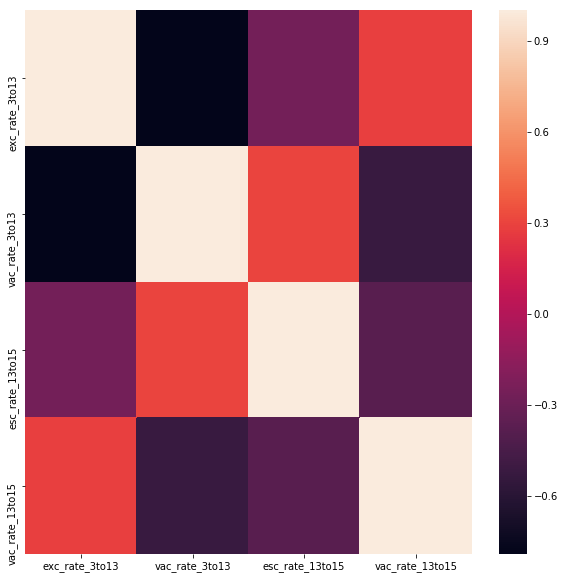

In [19]:
import seaborn as sns
plt.figure(figsize=(10,10));
sns.heatmap(summary.corr());
plt.savefig('figure_3.png');

Well as we expect, the exemption and vaccination rates are almost perfectly anti-correlated even on the county level. Interestingly, there is a anti-correlation between the rates of exemptions between 03-13 and those between 13-15, suggesting that some progress was made in decreasing exemption rates in counties that had a large increases.

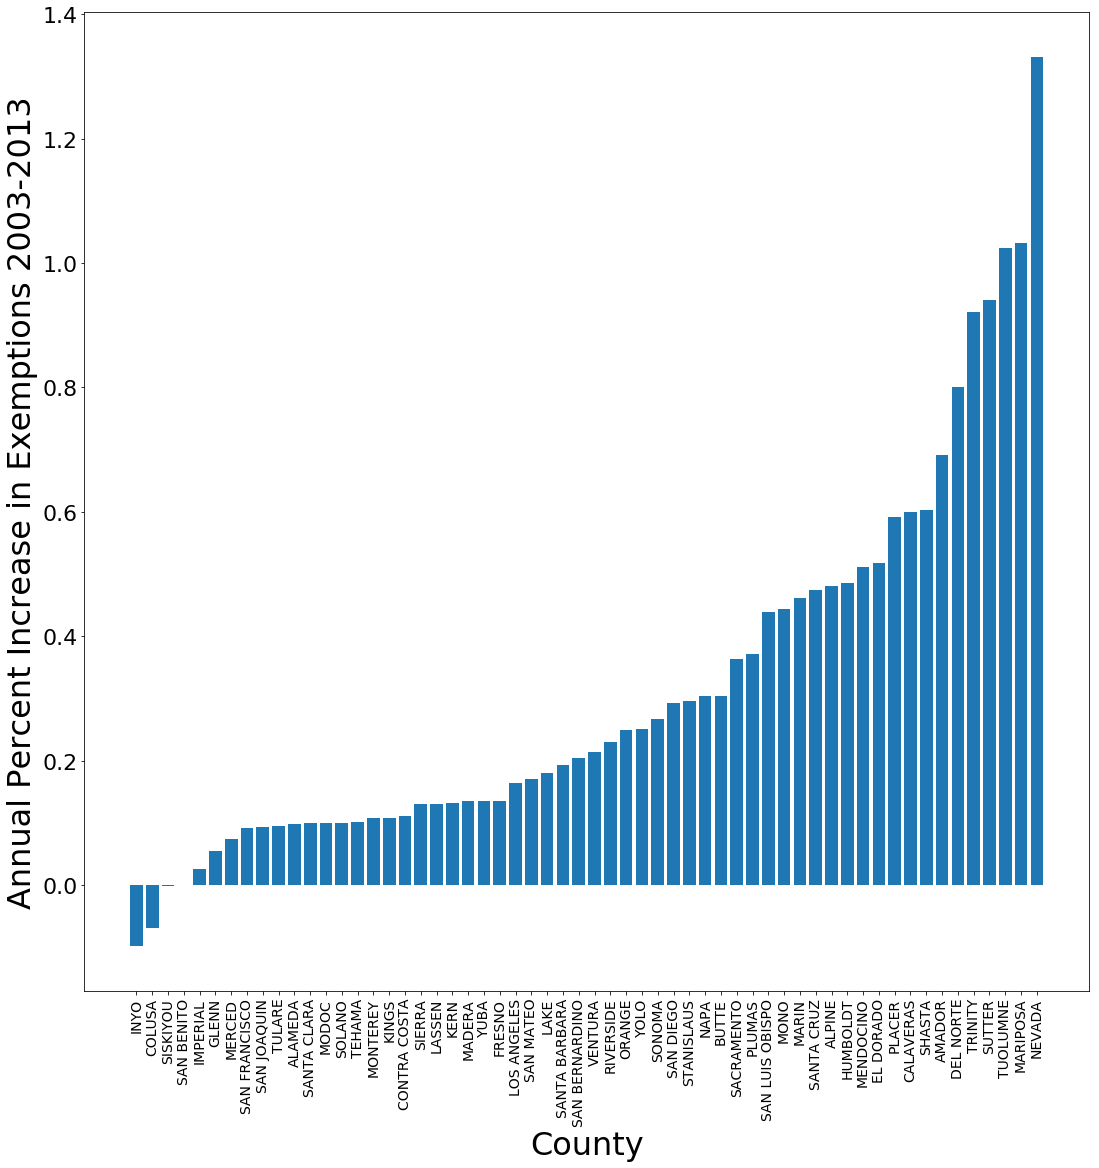

In [20]:
plt.figure(figsize=(18,18));
sort_df = summary['exc_rate_3to13'].sort_values()
plt.bar(sort_df.index.tolist(), sort_df.values*100);
plt.xlabel('County', fontsize=32);
plt.ylabel('Annual Percent Increase in Exemptions 2003-2013', fontsize=32);
plt.xticks(rotation='vertical', fontsize=14);
plt.yticks(fontsize=22);
plt.savefig('figure_4.png');

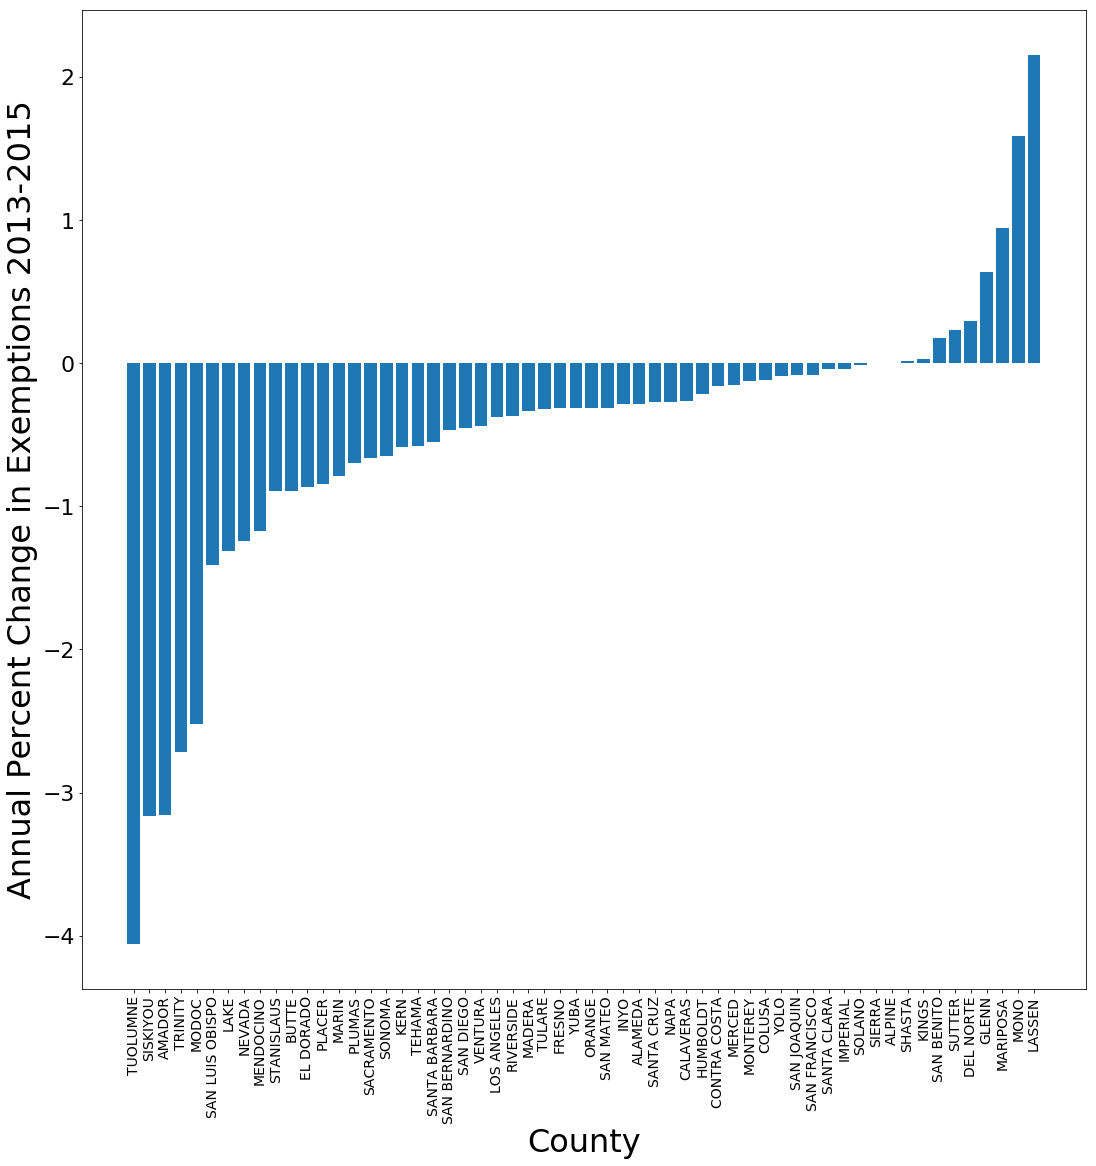

In [21]:
plt.figure(figsize=(18,18));
sort_df = summary['esc_rate_13to15'].sort_values()
plt.bar(sort_df.index.tolist(), sort_df.values*100);
plt.xlabel('County', fontsize=32);
plt.ylabel('Annual Percent Change in Exemptions 2013-2015', fontsize=32);
plt.xticks(rotation='vertical', fontsize=14);
plt.yticks(fontsize=22);
plt.savefig('figure_5.png')

## Map plotting section for adding to the dashboard

In [22]:
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import numpy as np
import pandas as pd

df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
df_sample_r = df_sample[df_sample['STNAME'] == 'California']
df_sample_r['CTYNAME'] = df_sample_r['CTYNAME'].str.extract('([\w ]+) County')[0].str.upper().tolist()
df_sample_r = df_sample_r.join(summary, on='CTYNAME', how='right')
df_sample_r = df_sample_r[['FIPS', 'CTYNAME', 'exc_rate_3to13', 'vac_rate_3to13', 'esc_rate_13to15', 'vac_rate_13to15']]


values = (df_sample_r['exc_rate_3to13']*100).tolist()
fips = df_sample_r['FIPS'].tolist()

colorscale = [
    'rgb(68.0, 1.0, 84.0)',
    'rgb(66.0, 64.0, 134.0)',
    'rgb(38.0, 130.0, 142.0)',
    'rgb(63.0, 188.0, 115.0)',
    'rgb(216.0, 226.0, 25.0)'
]

exm_2003_2013 = ff.create_choropleth(
    fips=fips, values=values, scope=['CA'],
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Annual Rate of Change', 
    title='Percent Change in Vaccine Personal Belief Exceptions 2003-2013'
)

py.iplot(exm_2003_2013, filename='Percent Change in Vaccine Personal Belief Exceptions 2003-2013')

C:\Users\Jeremy\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




Looks like the regions that showed large increases are geographically clustered. In particular, the regions in northern coastal California (Humboldt and Mendocino) and the counties along the northern part of the Sierra Nevada mountain range from Yosemite up past Tahoe all saw great than 0.5% annual increases during this time. All the large urban centers saw increases during this time, albeit at about half the rate of these rural areas.

My home county of Alameda showed a pretty small increase, <0.1%! Still an increase.

In [23]:
import plotly.plotly as py
import plotly.figure_factory as ff

import numpy as np
import pandas as pd

df_sample = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')
df_sample_r = df_sample[df_sample['STNAME'] == 'California']
df_sample_r['CTYNAME'] = df_sample_r['CTYNAME'].str.extract('([\w ]+) County')[0].str.upper().tolist()
df_sample_r = df_sample_r.join(summary, on='CTYNAME', how='right')
df_sample_r = df_sample_r[['FIPS', 'CTYNAME', 'exc_rate_3to13', 'vac_rate_3to13', 'esc_rate_13to15', 'vac_rate_13to15']]


values = (df_sample_r['esc_rate_13to15']*100).tolist()
fips = df_sample_r['FIPS'].tolist()

colorscale = [
    'rgb(68.0, 1.0, 84.0)',
    'rgb(66.0, 64.0, 134.0)',
    'rgb(38.0, 130.0, 142.0)',
    'rgb(63.0, 188.0, 115.0)',
    'rgb(216.0, 226.0, 25.0)'
]

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['CA'],
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Annual Rate of Change', 
    title='Percent Increase in Vaccine Personal Belief Exceptions 2013-2015'
)

py.iplot(fig, filename='Percent Change in Vaccine Personal Belief Exceptions 2013-2015')

C:\Users\Jeremy\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False




Looks like some progress has been made in the highest rate areas since 2013. Several of the highest rise areas form 03-13 showed some of the largest decreases in the personal exemption rates across this time. Nearly all of the counties in California decreased.

## Dicussion

Seems like something started going right around 2013/2014 that really slowed the trend of increasing PBEs since the early 2003. I would argue that the media surrounding this issue since this time has not super encouraging, with lots of [misinformaiton campaigns](https://www.learntherisk.org/vaccines/?gclid=EAIaIQobChMIpvfi7fzG4AIVkx6tBh3vPgswEAMYASAAEgLtJPD_BwE) going around the internet.

Were there any specific policy initiatives that took place around then? Turns out yes, there seems to be [one really important one](https://scholarworks.sjsu.edu/cgi/viewcontent.cgi?article=1034&context=etd_doctoral), California Assembly Bill 2109:

"As of January 2014, California Assembly Bill2109 (AB 2109, 2012)
mandated that parents seeking PBEs for state mandated immunizations for students entering
kindergarten were required to receive education about vaccine safety and risks along with
education regarding VPDs by a health care professional"

If this is indeed true, this suggests a powerful and minimally restrictive policy going forward that other states could model their own policies after.